That last notebook got messy so I'm making a new cleaner one that will enable me to sample over both emulators simultaneously. 

In [90]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [91]:
import numpy as np
import h5py
from pearce.emulator import LemonPepperWet
from os import path

In [92]:
training_file = '/home/users/swmclau2/scratch/vdf_zheng07/PearceVDFCosmo.hdf5'
#training_file = '/home/users/swmclau2/scratch/Aemulators/wp_zheng07/PearceWpCosmo.hdf5'

In [93]:
emu = LemonPepperWet(training_file, fixed_params = {'z':0.0})

 /home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:2825: UserWarning:WARNING: NaN detected. Skipped 0 points in training data.


In [94]:
h = 0.6777
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2-0.048206*h**2,\
                            -1, 0.9667, \
                                h*100, 3.046, 0.8228]) #mdpl2

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [95]:
cat_val_dict

{'H0': 67.77,
 'Neff': 3.046,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'w0': -1.0}

In [96]:
true_param_dict = cat_val_dict.copy()
hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
#hod_params = {'alpha': 0.95, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.5, 'sigma_logM': 0.2}#sim_info['hod_params']


hod_params['mean_occupation_centrals_assembias_corr1'] = 0.0
hod_params['mean_occupation_satellites_assembias_corr1'] =0.0
#hod_params['mean_occupation_centrals_assembias_slope1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_slope1'] = 0.0

#for pname in emu.get_param_names():
#    if 'mean_occupation' in pname:
#        hod_params[pname] = 0.0

for hp, hv in hod_params.iteritems():
    if hp == 'logMmin':
        continue
    true_param_dict[hp] = hv

true_param_dict['conc_gal_bias'] = 1.0
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

In [97]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'mean_occupation_centrals_assembias_corr1': 0.0,
 'mean_occupation_satellites_assembias_corr1': 0.0,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.2,
 'w0': -1.0}

In [98]:
true_pred = emu.emulate_wrt_r(true_param_dict).squeeze()

In [99]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'mean_occupation_centrals_assembias_corr1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_corr1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [100]:
sim_cov = np.load('/home/users/swmclau2/Git/pearce/bin/covmat/vdf_full_covmat.npy')
emu_cov = np.load('/home/users/swmclau2/Git/pearce/bin/optimization/vdf_hod_emu_cov_lpw.npy')

In [101]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

In [102]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

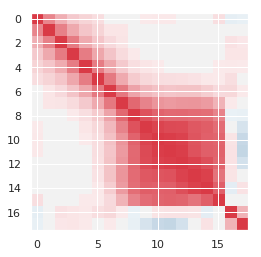

In [103]:
plt.imshow(cov_to_corr(sim_cov+emu_cov ) , cmap=cmap, vmin = -1)

In [104]:
yerr = np.sqrt(np.diag(sim_cov))#+emu_cov))

In [105]:
N = 4
cmap = sns.color_palette("BrBG_d", N)

[]

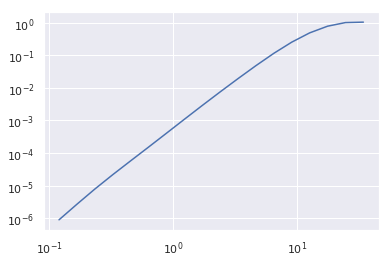

In [109]:
plt.plot(rbc, 10**true_pred)
plt.loglog()

[]

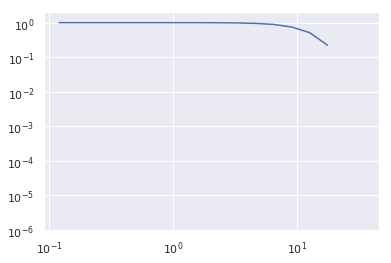

In [112]:
plt.plot(rbc, 1- 10**true_pred)
plt.ylim([1e-6, 2])
plt.loglog()

In [121]:
def plot_variation(varied_pname):
    fig = plt.figure(figsize=(8,5.5))
    #varied_pname = 'sigma_logM'
    lower, upper = emu.get_param_bounds(varied_pname)

    rbc = emu.scale_bin_centers
    plt.errorbar(rbc, np.ones_like(true_pred), yerr=yerr/(10**true_pred), label = 'Baseline',\
                 color = 'k', ls = '--', alpha = 0.5)  

    plt.xscale('log')
    for c, val in zip(cmap, np.linspace(lower, upper, N) ):
        param_dict = true_param_dict.copy()
        param_dict[varied_pname] = val

        pred = emu.emulate_wrt_r(param_dict).squeeze()
        plt.plot(rbc, (10**pred)/(10**true_pred), label = '%.3f'%val, color = c)

    plt.title(varied_pname)
    plt.legend(loc='best')
    plt.ylim([0.9, 1.1])
    plt.ylabel(r'$VPF/VPF_0$')
    #plt.ylabel(r'$wp/wp_0$')

    plt.xlabel(r'$r$ [Mpc]')
    plt.show();

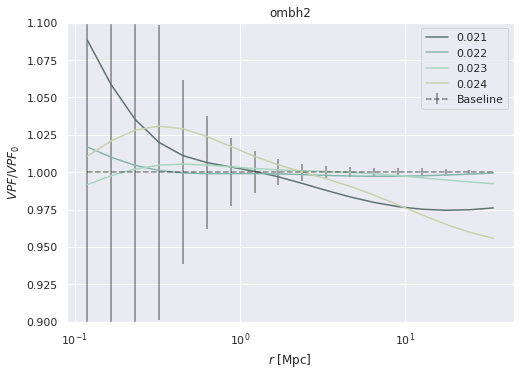

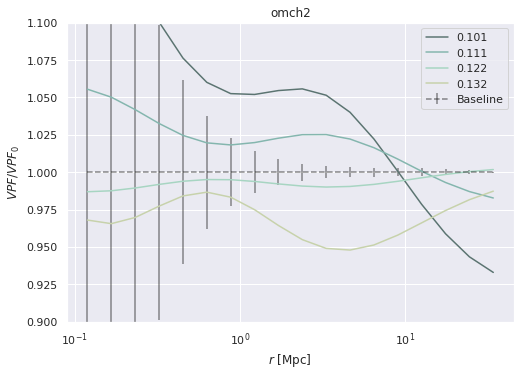

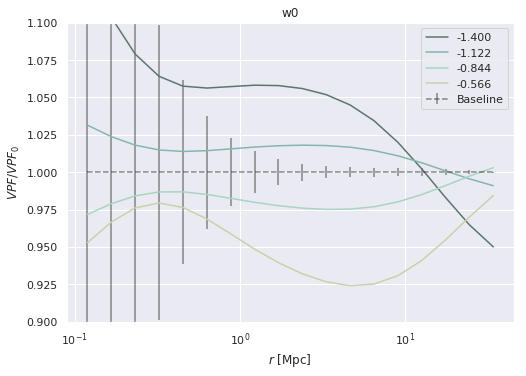

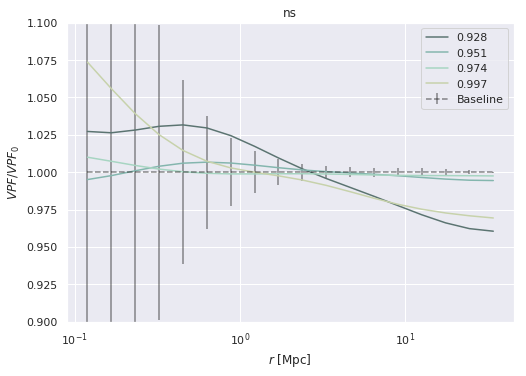

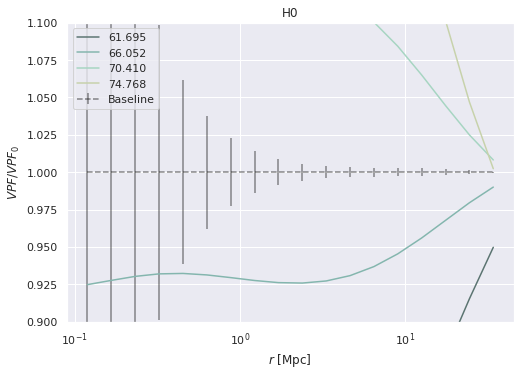

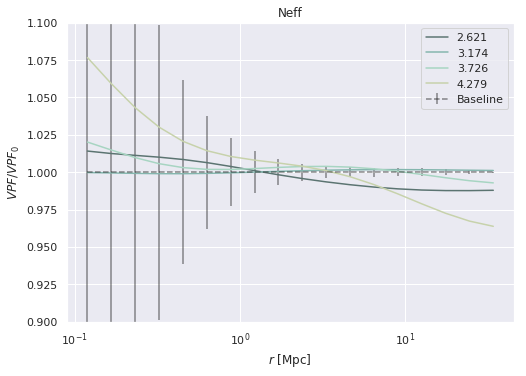

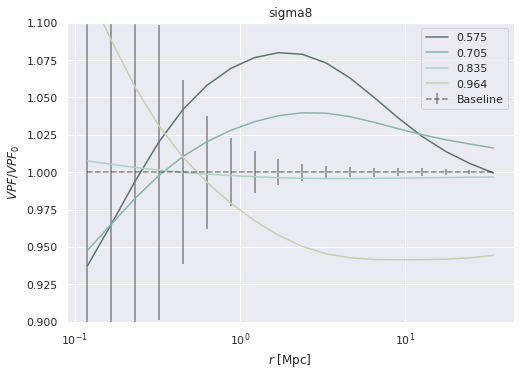

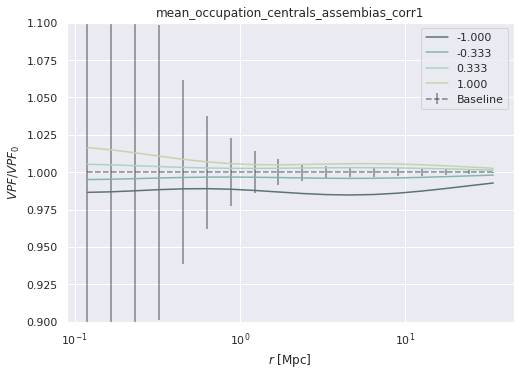

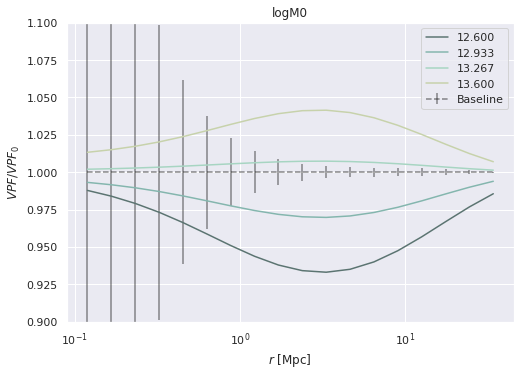

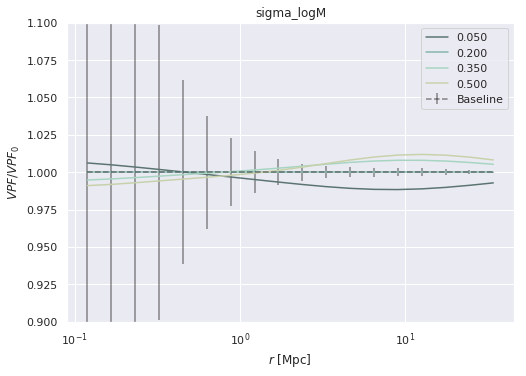

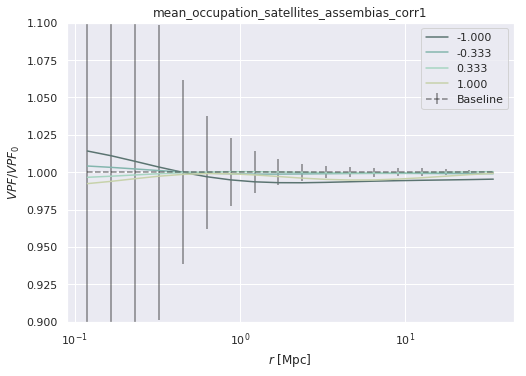

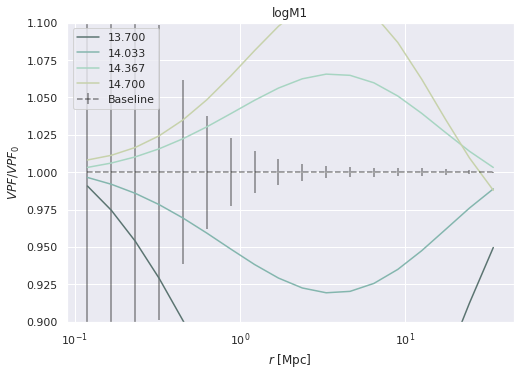

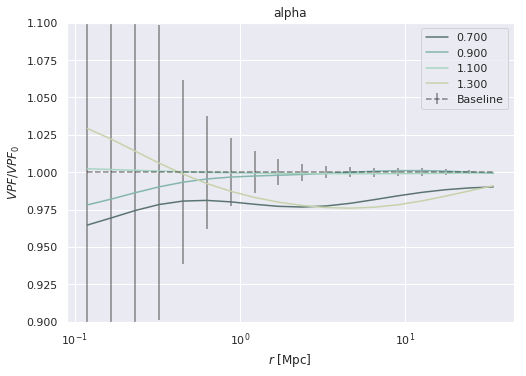

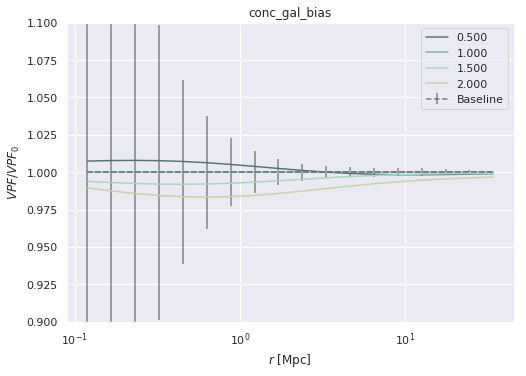

In [122]:
for vp in emu.get_param_names():
    plot_variation(vp)